<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Linear-Regression-Model" data-toc-modified-id="Linear-Regression-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression Model</a></span></li><li><span><a href="#Nonelinear-Model-using-Predictors" data-toc-modified-id="Nonelinear-Model-using-Predictors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nonelinear Model using Predictors</a></span></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Comparison</a></span></li><li><span><a href="#Fault-Detection-using-NL-Model" data-toc-modified-id="Fault-Detection-using-NL-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fault Detection using NL Model</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Can-we-predict-the-power-generation-for-next-couple-of-days?" data-toc-modified-id="Can-we-predict-the-power-generation-for-next-couple-of-days?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Can we predict the power generation for next couple of days?</a></span></li><li><span><a href="#Can-we-identify-the-need-for-panel-cleaning-or-maintenance?" data-toc-modified-id="Can-we-identify-the-need-for-panel-cleaning-or-maintenance?-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Can we identify the need for panel cleaning or maintenance?</a></span></li><li><span><a href="#Can-we-identify-faulty-or-suboptimally-performing-equipment?" data-toc-modified-id="Can-we-identify-faulty-or-suboptimally-performing-equipment?-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Can we identify faulty or suboptimally performing equipment?</a></span></li></ul></li></ul></div>

In [95]:
# Let's start with just one plant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
import warnings
import datetime
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

xformatter = mdates.DateFormatter('%H:%M') # for time axis plots
import sklearn
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')

In [72]:
gen1 = pd.read_csv('Plant_1_Generation_Data.csv')
sen1 = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

gen_1 = gen1.copy()
sen_1 = sen1.copy()
gen_1.drop(['PLANT_ID'],1, inplace = True)
sen_1.drop(['PLANT_ID'],1, inplace = True)

gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'], format = '%d-%m-%Y %H:%M')
sen_1['DATE_TIME'] = pd.to_datetime(sen_1['DATE_TIME'], format = '%Y-%m-%d %H:%M:%S')

#gen2 = pd.read_csv('Plant_2_Generation_Data.csv')
#sen2 = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

#gen2.drop(['PLANT_ID'], inplace = True)
#sen2.drop(['PLANT_ID'], inplace = True)

# drop unnecessary columns and merge both dataframes along DATE_TIME
df_plant1 = pd.merge(gen_1, sen_1.drop(columns = 'SOURCE_KEY'), on='DATE_TIME')
df_plant1["DATE"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.date # add new column with date
df_plant1["TIME"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.time 
df_plant1["DATE_STR"] = df_plant1["DATE"].astype(str)


In [73]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
# set normal daytime operation range
start=datetime.time(6,0,0) # sunrise
end=datetime.time(18,0,0) # sunset

# Create new column to check proper operation
# Return "Normal" if operation is normal and "Fault" if operation is faulty
df_plant1["STATUS"] = 0
for index in df_plant1.index:
    if  time_in_range(start, end, df_plant1["TIME"][index]) and df_plant1["DC_POWER"][index] == 0:
        df_plant1["STATUS"][index] = "Fault"
    else:
        df_plant1["STATUS"][index] = "Normal"


In [74]:
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION        DATE      TIME  \
0            25.184316           22.857507          0.0  2020-05-15  00:00:00   
1            25.184316           22.857507          0.0  2020-05-15  00:00:00   
2            25.184316           22.857507          0.0  2020-05-15  00:00:00   
3            25.184316           22.857507          0.0  2020-05-15  00:00:00   
4            25.184316           22.857507          0.0  2020-05-15  00:00:00   

     DATE_STR  STATUS  
0  2020-05-15  Normal  
1  2020-05-15  Normal  
2  2020-05-15  Normal  
3  2020-05-15  Normal  
4  2020-05-15  Normal

# Linear Regression Model

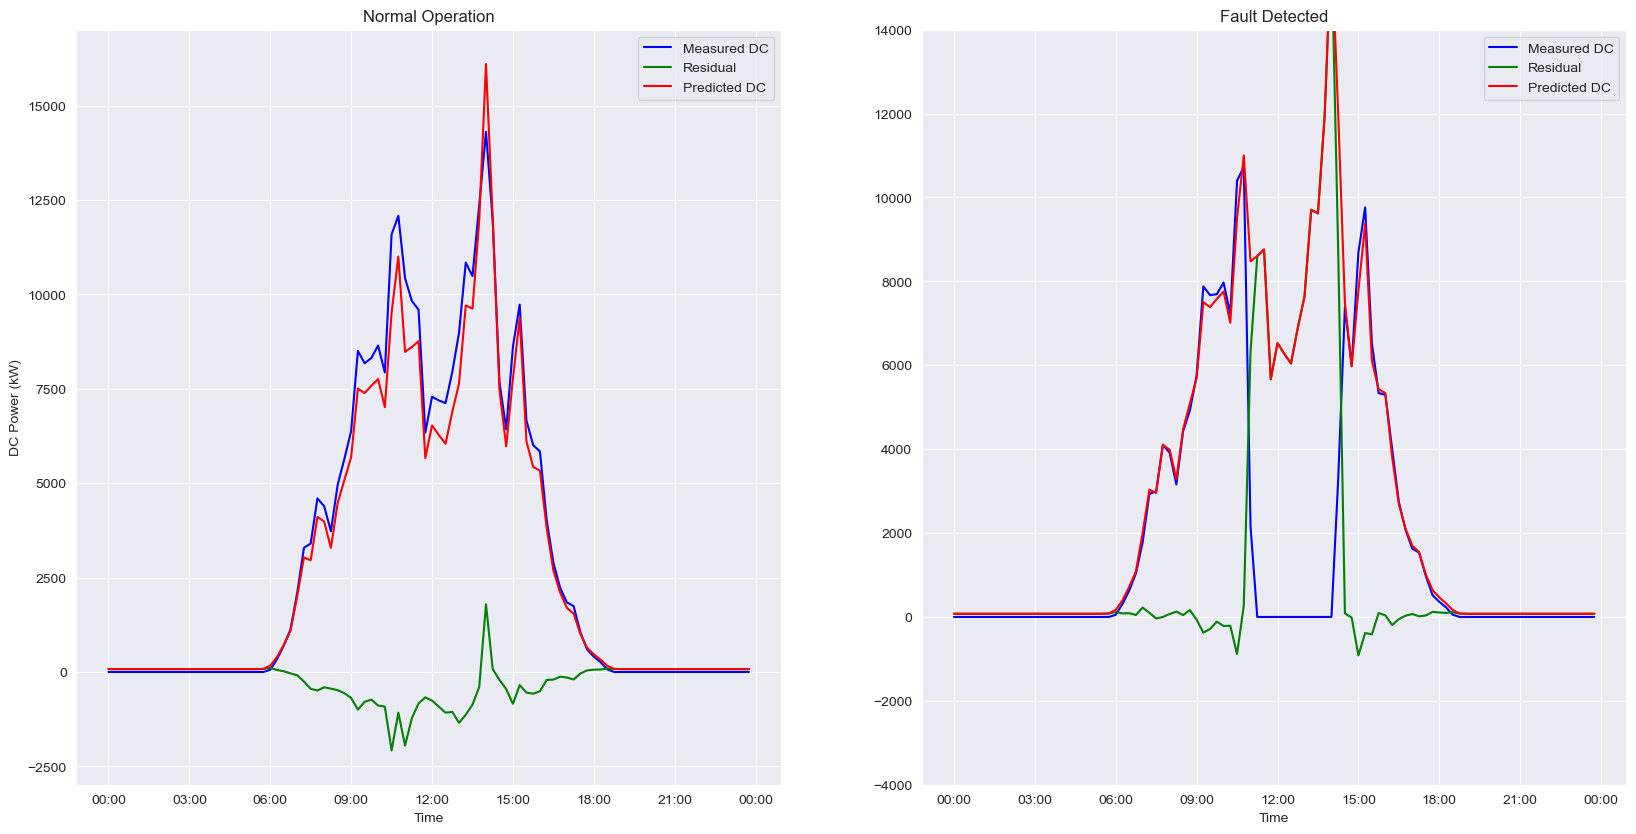

In [75]:
from sklearn.linear_model import LinearRegression

# Model
reg = LinearRegression()

# choose training data
df_train = df_plant1[:48000]

#train_dates = ["2020-05-16", "2020-05-17","2020-05-18" ,"2020-05-19", "2020-05-20", "2020-05-21"]
#df_train = df_plant1[df_plant1["DATE_STR"].isin(train_dates)]


#fit & predict
reg.fit(df_train[["IRRADIATION"]], df_train.DC_POWER)
prediction = reg.predict(df_plant1[["IRRADIATION"]])

# save prediction, residual, and absolute residual
df_train["Prediction"] = reg.predict(df_train[["IRRADIATION"]])
df_train["Residual"] = df_train["Prediction"] - df_train["DC_POWER"]
df_plant1["Prediction"] = reg.predict(df_plant1[["IRRADIATION"]])
df_plant1["Residual"] = df_plant1["Prediction"] - df_plant1["DC_POWER"]
df_plant1["Residual_abs"] = df_plant1["Residual"].abs()

# choose data
day = "2020-06-14"
inverter1 = "1IF53ai7Xc0U56Y"
inverter2 = "1BY6WEcLGh8j5v7"
df_pred = df_plant1[(df_plant1["DATE_STR"] == day)].copy()

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(20,10))
mask1 = df_pred["SOURCE_KEY"] == inverter1
mask2 = df_pred["SOURCE_KEY"] == inverter2
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['DC_POWER'], label="Measured DC", color="b", ax=ax[0])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['Residual'], label="Residual", color="g", ax=ax[0])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['Prediction'], label="Predicted DC", color="r", ax=ax[0])

sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['DC_POWER'], label="Measured DC", color="b", ax=ax[1])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['Residual'], label="Residual", color="g", ax=ax[1])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['Prediction'], label="Predicted DC", color="r", ax=ax[1])

plt.gcf().axes[0].xaxis.set_major_formatter(xformatter) # set xaxis format to time only
plt.gcf().axes[1].xaxis.set_major_formatter(xformatter) # set xaxis format to time only
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("DC Power (kW)")
ax[1].set_ylabel("")
ax[1].set_ylim(-4000, 14000)
ax[0].set_title("Normal Operation")
ax[1].set_title("Fault Detected")
plt.show()

# Nonelinear Model using Predictors

I will be using Hooda et al.'s non-linear model:
$$P(t) = aE(t) \biggl{(}1-b(T(t) + \frac{E(t)}{800}(c-20)-25)-dln(E(t)))\biggr{)}$$
where, E(t) = irradiance, T(t) = module tmperature, and a-d are the coefficients that will be calculated to predict the power output of the solar plant. 


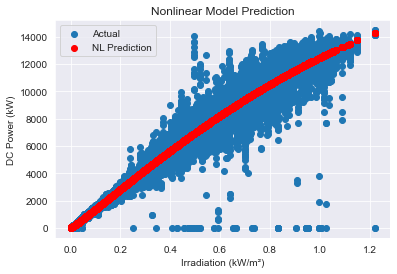

In [76]:

def func(X, a, b, c, d):
    '''Nonlinear function to predict DC power output from Irradiation and Temperature.'''
    #https://www.researchgate.net/publication/309399733_PV_Power_Predictors_for_Condition_Monitoring
    x,y = X
    x=x*1000
    y=y*1000
    return a*x*(1-b*(y+x/800*(c-20)-25)-d*np.log(x+1e-10))

p0 = [1.,0.,-1.e4,-1.e-1] # starting values
popt, pcov = curve_fit(func, (df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), df_train.DC_POWER, p0, maxfev=5000)
# popt = array of optimal values for paratmers that minimzes sum of squares of residuals
# pcov = 2D arry which has estimated covariance of popt. The sqrt of the diag will give us the sigma

sig = np.sqrt(np.diagonal(pcov))

# predict & save
df_train["Prediction_NL"] = func((df_train['IRRADIATION'], df_train['MODULE_TEMPERATURE']), *popt)
df_train["Residual_NL"] = df_train["Prediction_NL"] - df_train["DC_POWER"]

df_plant1["Prediction_NL"] = func((df_plant1['IRRADIATION'], df_plant1['MODULE_TEMPERATURE']), *popt)
df_plant1["Residual_NL"] = df_plant1["Prediction_NL"] - df_plant1["DC_POWER"]

plt.scatter(df_plant1['IRRADIATION'], df_plant1['DC_POWER'], label="Actual")
plt.scatter(df_plant1['IRRADIATION'], df_plant1['Prediction_NL'], color="r", label="NL Prediction")
plt.legend()
plt.xlabel("Irradiation (kW/m²)")
plt.ylabel("DC Power (kW)")
plt.title("Nonlinear Model Prediction")
plt.show()

We note that the data does have quite a residual, the NL model can help determine the expected by using an envelope to encompass variation in the solar train.

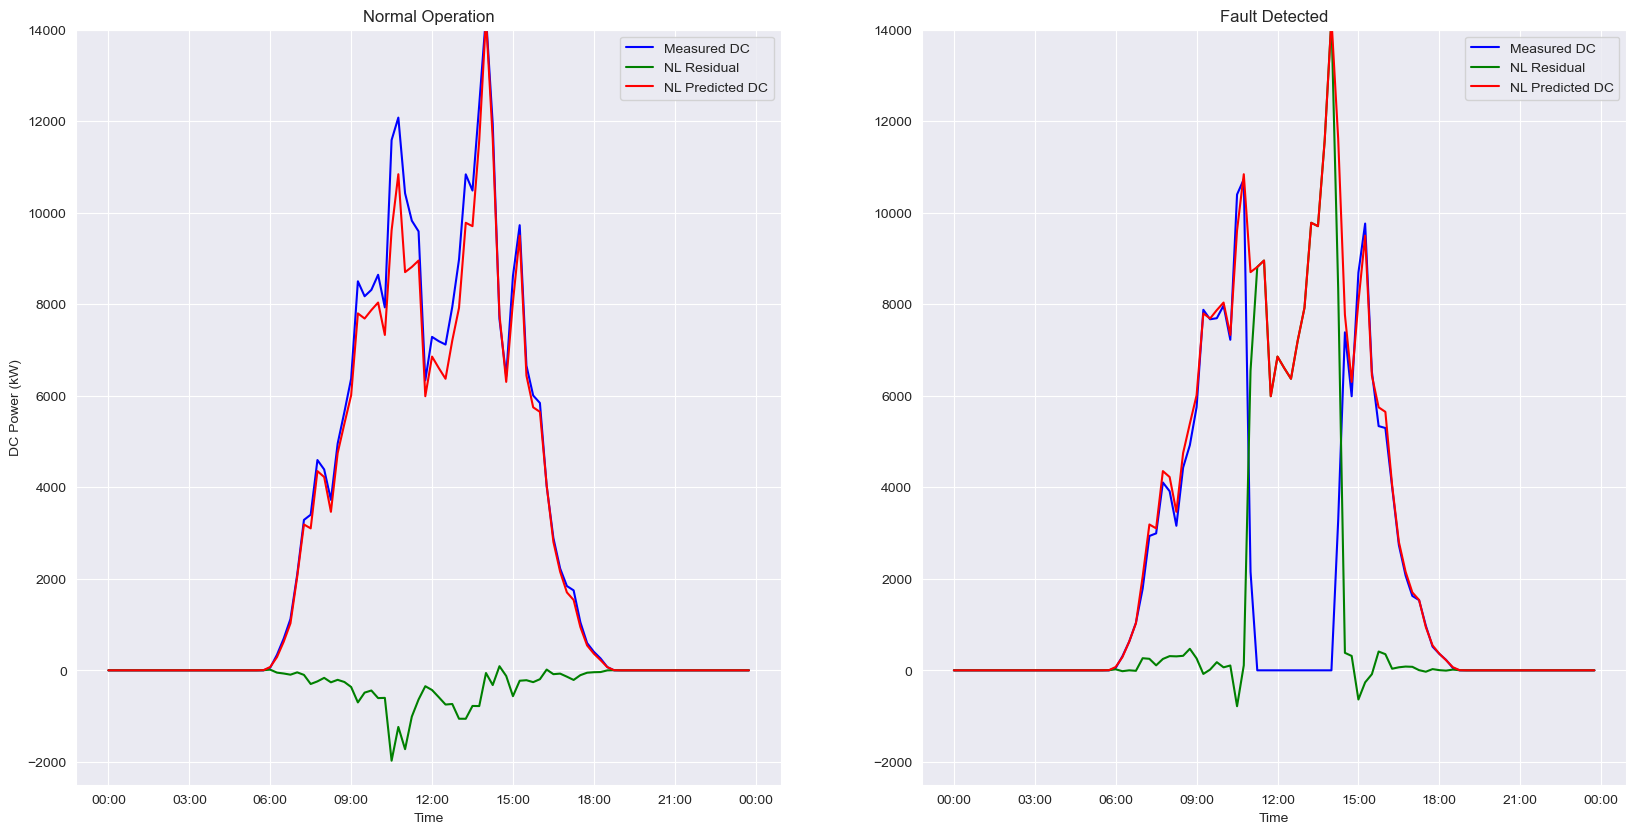

In [77]:
# choose data
day = "2020-06-14"
inverter1 = "1IF53ai7Xc0U56Y"
inverter2 = "1BY6WEcLGh8j5v7"
df_pred = df_plant1[(df_plant1["DATE_STR"] == day)].copy()

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(20,10))
mask1 = df_pred["SOURCE_KEY"] == inverter1
mask2 = df_pred["SOURCE_KEY"] == inverter2
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['DC_POWER'], label="Measured DC", color="b", ax=ax[0])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['Residual_NL'], label="NL Residual", color="g", ax=ax[0])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask1]['Prediction_NL'], label="NL Predicted DC", color="r", ax=ax[0])

sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['DC_POWER'], label="Measured DC", color="b", ax=ax[1])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['Residual_NL'], label="NL Residual", color="g", ax=ax[1])
sns.lineplot(df_pred['DATE_TIME'],df_pred[mask2]['Prediction_NL'], label="NL Predicted DC", color="r", ax=ax[1])

plt.gcf().axes[0].xaxis.set_major_formatter(xformatter) # set xaxis format
plt.gcf().axes[1].xaxis.set_major_formatter(xformatter) # set xaxis format
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("DC Power (kW)")
ax[1].set_ylabel("")
ax[0].set_ylim(-2500, 14000)
ax[1].set_ylim(-2500, 14000)
ax[0].set_title("Normal Operation")
ax[1].set_title("Fault Detected")

plt.show()

# Model Comparison

There are multiple ways to determine which model is better. For simplicity, we will compare the RMSE to determine the better fit. Note that the LR seems to over-predict over the 14,000 mark. It is possible that it is more accurate in the 8,000 - 14,000 kW range. In this case, we can use a piece-wise model to reduce the RMSE for the overall analysis. 

In [78]:
# https://plotly.com/python/line-and-scatter/
# Too much data that it lags - not including this. 
# fig = go.Figure()
# # Add Traces
# fig.add_trace(go.Scatter(x= df_train["Prediction"], y=df_train["Residual"], 
#                          mode = 'markers', name = 'Residual_LR'
#                         label = {"Prediction":"Predicted DW Power [kW]", "Residual":"Residual"}))
# fig.add_trace(go.Scatter(x= df_train["Prediction_NL"], y=df_train["Residual_NL"], 
#                          mode = 'markers', name = 'Residual_NL'))

# fig.show()


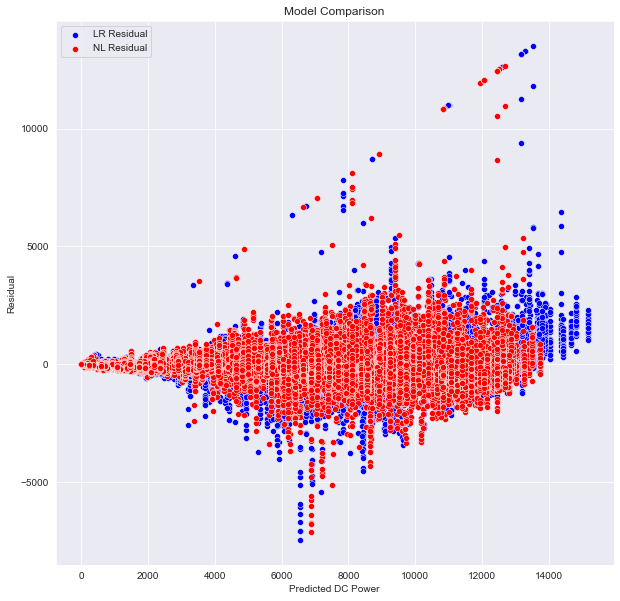

In [93]:
plt.figure(figsize=(10,10))
sns.scatterplot(df_train['Prediction'], df_train['Residual'], color="b", label="LR Residual")
sns.scatterplot(df_train['Prediction_NL'], df_train['Residual_NL'], color="r", label="NL Residual")
ax = plt.gca()
plt.ylabel("Residual")
plt.xlabel("Predicted DC Power")
plt.title("Model Comparison")
plt.show()

In [111]:
mse_LR = mean_squared_error(df_pred[mask1]['DC_POWER'],df_pred[mask1]['Prediction'], squared=False) 
mse_NL = mean_squared_error(df_pred[mask1]['DC_POWER'],df_pred[mask1]['Prediction_NL'], squared=False)

print(mse_LR)
print(mse_NL)

567.5544374884722
432.3723952705951


# Fault Detection using NL Model

In [112]:
# set confidence range for residual for fault
limit_fault=3000

# Create new column to check proper operation
# Return "Normal" if operation is normal and "Fault" if operation is faulty
df_plant1["STATUS_NL"] = 0
for index in df_plant1.index:
    if  df_plant1["Residual_NL"][index] > limit_fault:
        df_plant1["STATUS_NL"][index] = "Fault"  
    else:
        df_plant1["STATUS_NL"][index] = "Normal"
        

In [114]:
fig=px.bar(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["DATE"].value_counts(), title="Faults: Nonlinear Model", labels={"value":"Faults", "index":"Date", "SENSOR_NAME":"Inverter"}, )
fig.update(layout_showlegend=False)
fig.show()

fig=px.bar(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["SOURCE_KEY"].value_counts(), title="Underperformance & Faults: Nonlinear Model", labels={"value":"Faults", "index":"Inverter", "SENSOR_NAME":"Inverter"})
fig.update(layout_showlegend=False)
fig.show()

In [115]:
fig = px.scatter(df_plant1, x="DATE_TIME", y="DC_POWER", title="Identifying Faults", color="STATUS_NL", 
                 labels={"DC_POWER":"DC Power [kW]", "DATE_TIME":"Time", "STATUS_NL":"Status"},
                 range_x=[datetime.date(2020, 6, 6), datetime.date(2020, 6, 15)])
fig.update_traces(marker=dict(size=1, opacity=0.7), selector=dict(mode='marker'))
fig.show()

Let's talk the significance of the data above. In a seasonal data, it can be hard to distingusih faults due to the vast amount of data points. The anomalies can be lost and easily forgotten when DC_Power is greater than zero. This is lost dollars and opportunities that can be fixed through preventative maintenace. 

# Summary

## Can we predict the power generation for next couple of days?
We were able to create code to test the prediction for the following days 1-2 days to estimate the power usage. The next steps would be to use ambient temperature or weather station data estimate irradiation then predict DC_POWER. We can apply it real time to a process historian to help operators track generation.

##  Can we identify the need for panel cleaning or maintenance?
We were able to identify events of underperformance which includes equipment failures. We used linear regression and non-linear modeling to predict DC_Power using irradiance and module temperature. This can easily be used for an operator to clean or perform maintenace. Note that it does not specify the exact issue with the solar panel, but it can distinguish between inverter or solar panel. 

##  Can we identify faulty or suboptimally performing equipment?
Yes, we can! See note above


<b>Thank you for reading my notebook and please leave a review on how I can improve!